In [30]:
# import required packages
import pandas as pd
import numpy as np

import shap
import joblib
import dice_ml

from sklearn import preprocessing
import warnings
import random
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
import xgboost as xgb
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix

In [31]:
random_state = random.randint(0, 100)
print('seed', random_state)

warnings.filterwarnings("ignore")

seed 27


In [32]:
x_cols = ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar',
       'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'color']
label = 'quality'

df = pd.read_csv("./data/Wine_Quality_Data.csv")


L=LabelEncoder()
df["color"]=L.fit_transform(df["color"])

# Map classes accordingly
dic = { 3: 0 , 4: 0, 5:1, 6:1, 7:2, 8:2, 9:2} 
df[label] = df[label].map(dic)

In [33]:
# Identifying target feature and other features
X = df[x_cols]
y = df[label]

# Raw split of dataset 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)  

train = X_train.join(y_train)
test = X_test.join(y_test)

# Save raw training and testing data
train.to_csv('./data/train.csv',index=False) 
test.to_csv('./data/test.csv',index=False)


# Over-sampling the train set 
oversample = SMOTE(random_state=random_state,k_neighbors=2)
X_train_os, y_train_os = oversample.fit_resample(X_train, y_train)
train_os = X_train_os.join(y_train_os)

# Over-sampled train set
train_os.to_csv('./data/train_oversampled.csv',index=False)

print(y_train.value_counts())
print(y_train_os.value_counts())
print(y_test.value_counts())

1    3503
2     870
0     174
Name: quality, dtype: int64
1    3503
0    3503
2    3503
Name: quality, dtype: int64
1    1471
2     407
0      72
Name: quality, dtype: int64


In [34]:
# Group samples up to classes
X_train.loc[train[label] == 0].to_csv('./data/train_c0.csv',index=False) 
X_train.loc[train[label] == 1].to_csv('./data/train_c1.csv',index=False) 
X_train.loc[train[label] == 2].to_csv('./data/train_c2.csv',index=False) 

# Group samples up to classes
X_train_os.loc[train_os[label] == 0].to_csv('./data/train_os_c0.csv',index=False) 
X_train_os.loc[train_os[label] == 1].to_csv('./data/train_os_c1.csv',index=False) 
X_train_os.loc[train_os[label] == 2].to_csv('./data/train_os_c2.csv',index=False) 

Using 500 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/100 [00:00<?, ?it/s]

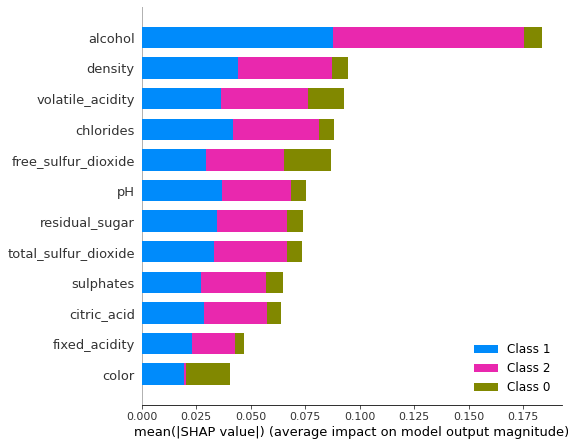

In [35]:
# build the lightgbm model
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X, y)

# Create shap kernel explainer using model and training data
explainer = shap.KernelExplainer(xgb_model.predict_proba, shap.kmeans(X, 500))

# Shap values calculated by explainer
shap_values = explainer.shap_values(X.sample(100))

# Bar plot of calculated shap values (Each color implies a class)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [36]:
# min_max_scaler = preprocessing.MinMaxScaler()

# vals= np.mean(np.abs(min_max_scaler.fit_transform(shap_values[0])), axis=0)
vals= np.mean(np.abs(shap_values[0]), axis=0)

feature_importance = pd.DataFrame(list(zip(X_test.columns, vals)), columns=['col_name','shap'])

feature_importance.sort_values(by=['shap'], ascending=False,inplace=True)
feature_importance = feature_importance.set_index('col_name')
feature_importance0 = feature_importance.append(pd.Series([0], index=feature_importance.columns, name=label))
feature_importance0.to_csv('./shap_val/shap0.csv')


# vals= np.mean(np.abs(min_max_scaler.fit_transform(shap_values[1])), axis=0)
vals= np.mean(np.abs(shap_values[1]), axis=0)

feature_importance = pd.DataFrame(list(zip(X_test.columns, vals)), columns=['col_name','shap'])

feature_importance.sort_values(by=['shap'], ascending=False,inplace=True)
feature_importance = feature_importance.set_index('col_name')
feature_importance1 = feature_importance.append(pd.Series([0], index=feature_importance.columns, name=label))
feature_importance1.to_csv('./shap_val/shap1.csv')



# vals= np.mean(np.abs(min_max_scaler.fit_transform(shap_values[2])), axis=0)
vals= np.mean(np.abs(shap_values[2]), axis=0)

feature_importance = pd.DataFrame(list(zip(X_test.columns, vals)), columns=['col_name','shap'])

feature_importance.sort_values(by=['shap'], ascending=False,inplace=True)
feature_importance = feature_importance.set_index('col_name')
feature_importance2 = feature_importance.append(pd.Series([0], index=feature_importance.columns, name=label))
feature_importance2.to_csv('./shap_val/shap2.csv')

In [37]:
def find_iqr(x):
    return np.subtract(*np.percentile(x, [75, 25]))

#calculate IQR for 'rating' and 'points' columns
df.apply(find_iqr)

fixed_acidity            1.30000
volatile_acidity         0.17000
citric_acid              0.14000
residual_sugar           6.30000
chlorides                0.02700
free_sulfur_dioxide     24.00000
total_sulfur_dioxide    79.00000
density                  0.00465
pH                       0.21000
sulphates                0.17000
alcohol                  1.80000
quality                  0.00000
color                    0.00000
dtype: float64